<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pandas as pd
import patsy

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%run helper.py

---

Lets start by importing the variables of interest from our other projects.

---

In [2]:
#Takes the variables of interest from Project 3 - Part 1
%store -r house

In [3]:
#Taking a look to ensure we have the correct dataset
house.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,Remod_Age,Total_SF,LogSalePrice,NeighborhoodPrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,208500,7,7,2566,12.247694,197200
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,5,2007,WD,Normal,181500,34,34,2524,12.109011,218000
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,9,2008,WD,Normal,223500,9,8,2706,12.317167,197200



---

**Baseline**

For a classifier model, we must first look into the baseline for comparison.

This is defined as the proportion of abnormal sales. In this case where the proportion is 6.58% there is a severe class imbalance. We're going to need to look into its relationship with various other variables.

---


In [4]:
#Number of abnormals
num_abnorm = (house["SaleCondition"] == "Abnorml").sum()
abnorm_perc = num_abnorm/len(house["SaleCondition"])
baseline = 100- abnorm_perc*100

print("The baseline percent for abnormal houses is {:.3f}%".format((baseline)))

The baseline percent for abnormal houses is 93.416%


In [5]:
#Creates a column determining if the house was abnormal for ease of evaluation: house["Abnormal]
house["Abnormal"] = house["SaleCondition"].map(lambda x: 1 if x == "Abnorml" else 0);


---

**Abnormal vs Sales Price**

Does the sales price have any significant influence on the sale being abnormal?

---


In [6]:
#Finds the median house price for if it's abnormal vs not.
abnorm_saleprice = house.groupby("Abnormal")["SalePrice"].median()

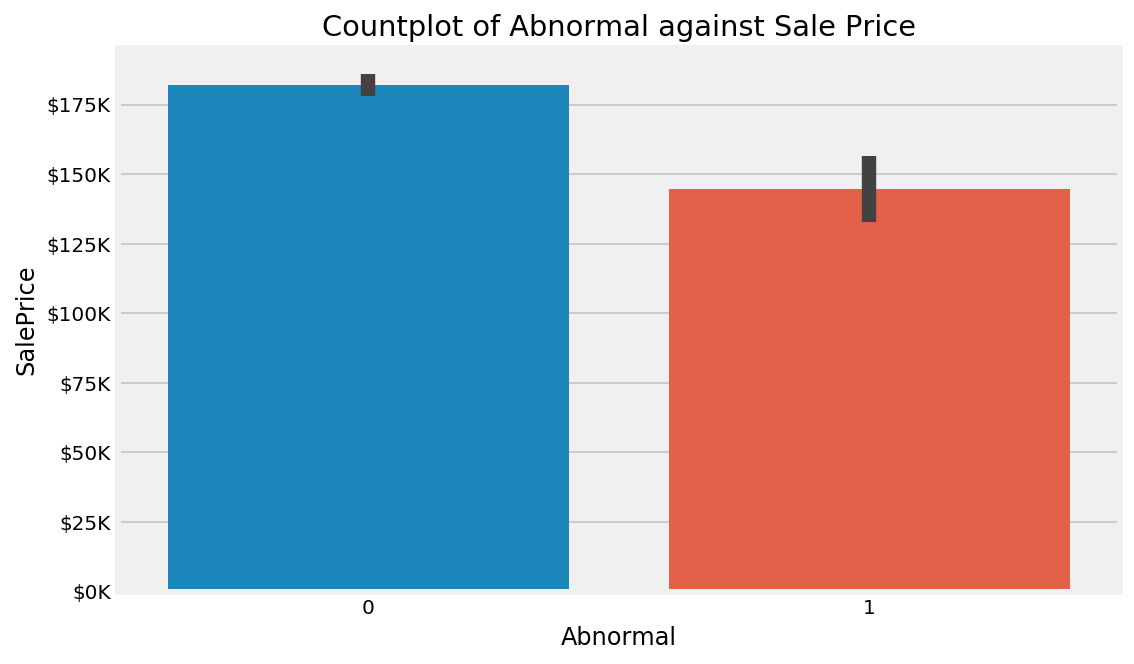

In [7]:
#Plots Sale Price against Abnormalities
fig, ax = plt.subplots(figsize = (8,5))

sns.barplot(x='Abnormal', y='SalePrice', data=house, ax = ax)

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title("Countplot of Abnormal against Sale Price")

plt.show()

In [8]:
#Testing the hypothesis
news_model = sm.logit("Abnormal ~ SalePrice", data=house).fit()
news_model.summary()

Optimization terminated successfully.
         Current function value: 0.232305
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Abnormal   No. Observations:                 1443
Model:                          Logit   Df Residuals:                     1441
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:                 0.04295
Time:                        00:44:02   Log-Likelihood:                -335.22
converged:                       True   LL-Null:                       -350.26
                                        LLR p-value:                 4.134e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9795      0.333     -2.944      0.003      -1.632      -0.327
SalePrice  -1.041e-05   2.15e-06     -4.832      0.000   -1.46e-05   -6.19e-06
==============================================================================
"""

**Results**

From the P-value, it appears that Saleprice has a significant affect on whether or not the sale was Abnormal. It seems that the SalePrice has a strong negative effect on abnormality.

We will add this to our model to evaluate later.




---

**Abnormal vs NeighborhoodPrice**

Does the neighborhood price have any significant influence on the sale being abnormal?

---


In [9]:
# Finds the number of Abnormal Sales by neighborhood
abnorm_neighborhoodprice = house.groupby("NeighborhoodPrice")["Abnormal"].count()

In [10]:
#Testing the hypothesis
model = sm.logit("Abnormal ~ NeighborhoodPrice", data=house).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.238327
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Abnormal   No. Observations:                 1443
Model:                          Logit   Df Residuals:                     1441
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:                 0.01814
Time:                        00:44:02   Log-Likelihood:                -343.91
converged:                       True   LL-Null:                       -350.26
                                        LLR p-value:                 0.0003642
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.3315      0.395     -3.369      0.001      -2.106      -0.557
NeighborhoodPrice     -8e-06   2.42e-06     -3.303      0.001   -1.27e-05   -3.25e-06
=====================================================================================
"""

**Results**

It appears that the NeighborhoodPrice has a significant effect on the sales abnormality


---

**Abnormal vs OverallQual & OverallCond**

We had good success with Quality and Condition in part 2. Can it help us here?

---


In [11]:
#Finds the median house price for if it's abnormal vs not.
abnorm_cond = house.groupby("Abnormal")["OverallCond"].count()
abnorm_qual = house.groupby("Abnormal")["OverallQual"].count()

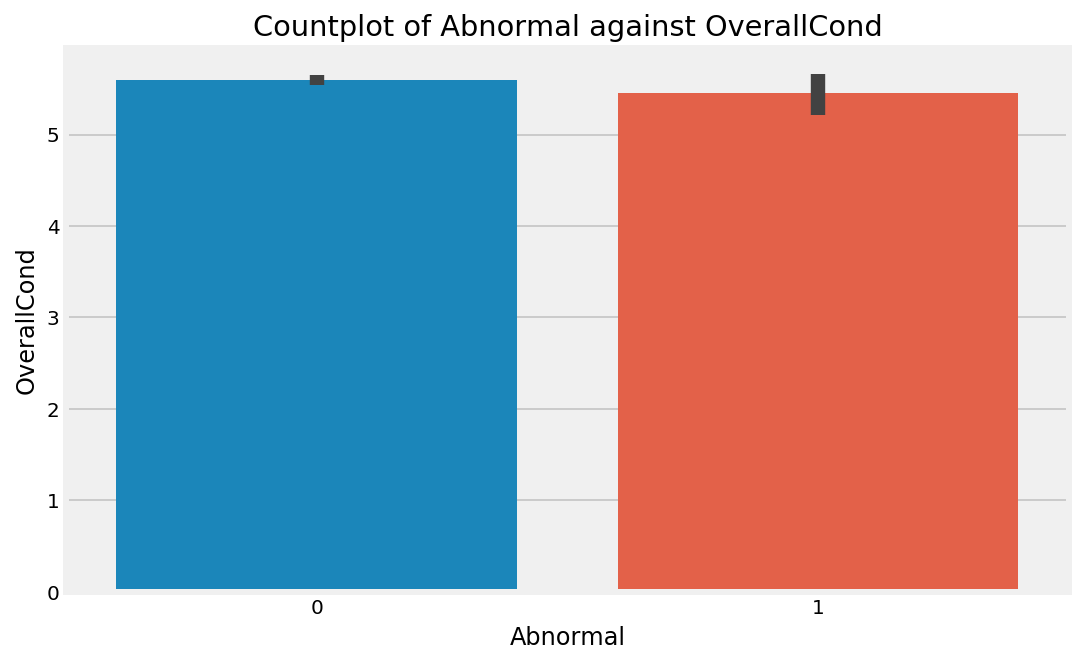

In [12]:
#Plots Overall Condition against Abnormalities
fig, ax = plt.subplots(figsize = (8,5))

sns.barplot(x='Abnormal', y='OverallCond', data=house, ax = ax)

ax.set_title("Countplot of Abnormal against OverallCond")

plt.show()

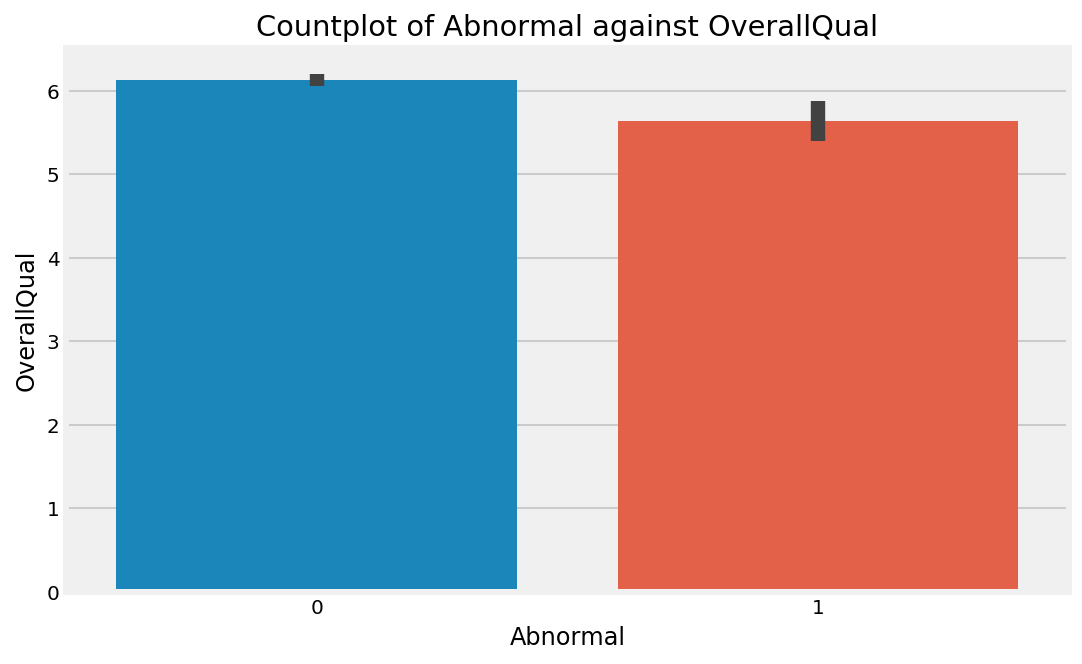

In [13]:
#Plots Sale Price against Abnormalities
fig, ax = plt.subplots(figsize = (8,5))

sns.barplot(x='Abnormal', y='OverallQual', data=house, ax = ax)

ax.set_title("Countplot of Abnormal against OverallQual")

plt.show()

In [14]:
#Testing the hypothesis
model = sm.logit("Abnormal ~ OverallQual + OverallCond", data=house).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.238023
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Abnormal   No. Observations:                 1443
Model:                          Logit   Df Residuals:                     1440
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:                 0.01939
Time:                        00:44:03   Log-Likelihood:                -343.47
converged:                       True   LL-Null:                       -350.26
                                        LLR p-value:                  0.001123
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.3474      0.684     -0.508      0.612      -1.688       0.994
OverallQual    -0.2746      0.080     -3.423      0.001      -0.432      -0.117
OverallCond    -0.1245      0.094     -1.318      0.187      -0.310       0.061
===============================================================================
"""

**Results**

Unfortunately it appears that neither have any affect on the abnormality

---

**Abnormal vs YrSold**

After some discussion with Brian, it would make sense to that YrSold would have an impact on the abnormality of the sale. Due to the GFC in 2007 we would expect that a larger portion of abnormalities would occur around this period.

---

In [15]:
#Groups the abnormalities by YearSold
abnorm_yrsold = house.groupby("YrSold")["Abnormal"].count()

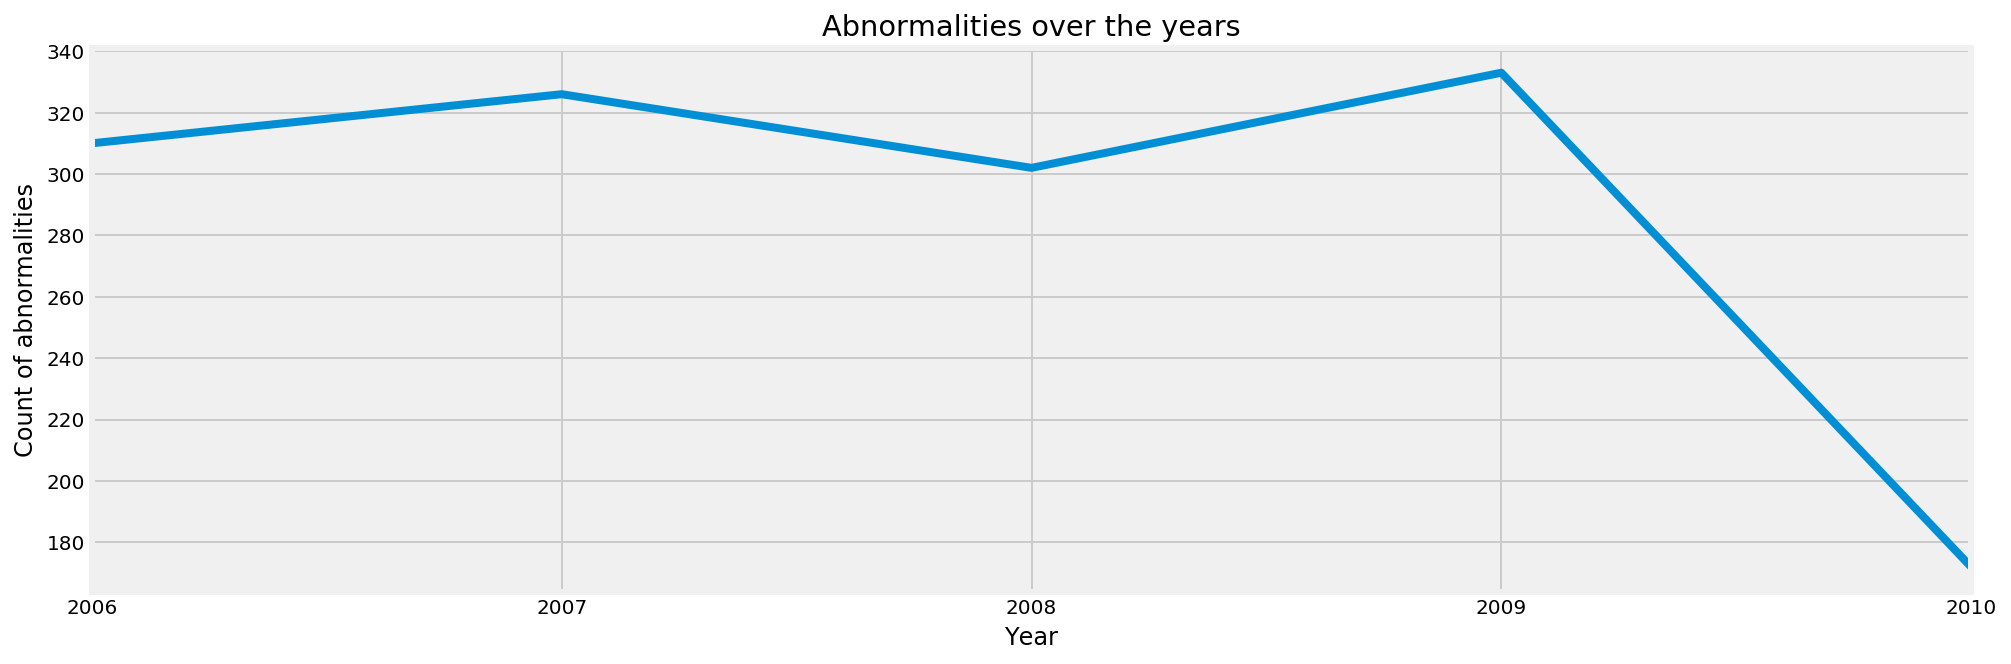

In [16]:
#Plots the abnormalities over the years
fig, ax = plt.subplots(figsize = (15,5))

sns.tsplot(abnorm_yrsold, time=abnorm_yrsold.index)

ax.set_title("Abnormalities over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Count of abnormalities")

ax.set_xticks([2006, 2007, 2008, 2009, 2010])

plt.show()

In [17]:
#Creates a new column: Sale_age
house["Sale_Age"] = house["YrSold"].map(lambda x: 2010 - x)

In [18]:
#Testing the hypothesis
model = sm.logit("Abnormal ~ Sale_Age", data=house).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.241897
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Abnormal   No. Observations:                 1443
Model:                          Logit   Df Residuals:                     1441
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:                0.003430
Time:                        00:44:03   Log-Likelihood:                -349.06
converged:                       True   LL-Null:                       -350.26
                                        LLR p-value:                    0.1211
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9380      0.220    -13.336      0.000      -3.370      -2.506
Sale_Age       0.1252      0.081      1.540      0.123      -0.034       0.284
==============================================================================
"""

**Results**

Even though effects of Sale_Age is supposedly not significant on abnormalities. I am still going to use it to predict abnormalities. 

The affects of Sale_Age appear to be positive, meaning that the earlier years 2006/2007 had more abnormalities. This intuitively makes sense due to the Global Financial Crisis that occured in '06 '07.

---

Preparing the model
---

From our naive observations, we are going to take the SalesPrice and OverallQual of a house to attempt to classify the abnormality of its sale.

Abnormality ~ SalesPrice + Sale_Age

We attempt this Logistic Regression, SVM and KNN

Since the abnormalities experience heavy class imbalance we are taking a 50:50 train:test split instead of the usual 80:20. This is so that the model has more abnormalities that it can work off.

---

---

**Logistic Regression**

---

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Setting up predictors and target
X = house[["SalePrice", "Sale_Age"]]
y = house["Abnormal"]

#Standardising
ss = StandardScaler()
Xs = ss.fit_transform(X)

# Logistic Regression: lr
lr = LogisticRegression()

#Splits Dataset into test train 50:50 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)
model = lr.fit(X_train, y_train)

#Stores predictions and predicted probabilities: yhat, yhat_pp
yhat = model.predict(X_test)
yhat_pp = model.predict_proba(X_test)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

#Confusion Matrix: conmat
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index = ["Actual Abnormal", "Actual Normal"], columns = ["Predicted Abnormal",\
                                                                                          "Predicted Normal"])
confusion

,Predicted Abnormal,Predicted Normal
Actual Abnormal,0,42
Actual Normal,0,680


---

**Logistic Regression - Metrics**

We're going to look into a few metrics now. We're going to look at

+ Precision
+ Recall
+ F1-score
+ Support

To note: Since there is such a large class imbalance, we generally are unable to draw many insights from the accuracy. For example the baseline accuracy 93.4165 after a logistic regression on SalesPrice the accuracy remainds to be 93.4165


---

In [21]:
from sklearn.metrics import classification_report
log_report = classification_report(y_test, yhat)
print (log_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       680
           1       0.00      0.00      0.00        42

    accuracy                           0.94       722
   macro avg       0.47      0.50      0.49       722
weighted avg       0.89      0.94      0.91       722



---

**K-NN**

---

In [22]:
from sklearn.neighbors import KNeighborsClassifier

#Splits Dataset into test train 50:50 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

#Creates the KNN model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

#Stores predictions and predicted probabilities: yhat, yhat_pp
yhat = model.predict(X_test)
yhat_pp = model.predict_proba(X_test)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

#Confusion Matrix: conmat
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index = ["Actual Abnormal", "Actual Normal"], columns = ["Predicted Abnormal",\
                                                                                          "Predicted Normal"])
confusion

,Predicted Abnormal,Predicted Normal
Actual Abnormal,0,42
Actual Normal,0,680


In [24]:
from sklearn.metrics import classification_report
knn_report = classification_report(y_test, yhat)
print (knn_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       680
           1       0.00      0.00      0.00        42

    accuracy                           0.94       722
   macro avg       0.47      0.50      0.49       722
weighted avg       0.89      0.94      0.91       722



---

**SVM - Linear Kernel**

---

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

#Splits Dataset into test train 50:50 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

#Creates the SVM Linear model
lin_model = SVC(kernel='linear')
lin_model.fit(X_train, y_train)

yhat = lin_model.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

#Confusion Matrix: conmat
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index = ["Actual Abnormal", "Actual Normal"], columns = ["Predicted Abnormal",\
                                                                                          "Predicted Normal"])
confusion

,Predicted Abnormal,Predicted Normal
Actual Abnormal,0,42
Actual Normal,1,679


In [27]:
from sklearn.metrics import classification_report
svm_report = classification_report(y_test, yhat)
print (svm_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       680
           1       0.00      0.00      0.00        42

    accuracy                           0.94       722
   macro avg       0.47      0.50      0.48       722
weighted avg       0.89      0.94      0.91       722



---

**SVM - Radial Basis Function Kernel**

---

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

#Splits Dataset into test train 50:50 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

#Creates the SVM Linear model
lin_model = SVC(kernel='rbf')
lin_model.fit(X_train, y_train)

yhat = lin_model.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

#Confusion Matrix: conmat
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index = ["Actual Abnormal", "Actual Normal"], columns = ["Predicted Abnormal",\
                                                                                          "Predicted Normal"])
confusion

,Predicted Abnormal,Predicted Normal
Actual Abnormal,0,42
Actual Normal,5,675


Part 3 - Conclusion
---

---

With Sales Price and Sale_Age alone, we are unable to accurately idently abnormalities.

We would need to further tweak with the threshhold to make the models more sensitive to abnormalities. 

---